<a href="https://www.kaggle.com/code/ragavpalaniswamy/106122095-ragav-palaniswamy-task2-ipynb?scriptVersionId=140952771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import json
from PIL import Image
import io
import requests
import random as rd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Step 1: Dataset Preparation
class CustomDataset(Dataset):
    def __init__(self, json_file, max_samples=10000, tokenizer = None, max_length = 32):
        self.data = self.load_data(json_file)
        rd.shuffle(self.data)  # Shuffle the data
        self.max_samples = max_samples
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        rd.shuffle(self.data)

        for item in self.data:
            if len(self.samples) >= self.max_samples:
                break

            image_url = item['url']
            image = self.load_image(image_url)
            if image is not None:
                caption = item['caption_en']
                encoded_caption = self.preprocess_caption(caption)
                self.samples.append((image, encoded_caption))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image, caption, one_hot_label = self.samples[index]
        return image, caption, one_hot_label

    def load_data(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        return data

    def load_image(self, image_url):
        try:
            response = requests.get(image_url)
            response.raise_for_status()  # Raise an exception for any HTTP error
            image = Image.open(io.BytesIO(response.content)).convert("RGB")

            transform = transforms.Compose([
                transforms.Resize((224, 224)),  # Resize the image to a specific size
                transforms.ToTensor(),  # Convert the image to a tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
            ])

            image = transform(image)

            return image

        except (requests.exceptions.HTTPError, OSError, IOError) as e:
            # print(f"Error loading image from URL: {image_url}")
            return None
    
    def preprocess_caption(self,text):

        # Tokenize the text and add special tokens [CLS] and [SEP]
        tokens = ["[CLS]"] + self.tokenizer.tokenize(text) + ["[SEP]"]

        # Convert tokens to token IDs
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Create attention mask
        attention_mask = [1] * len(input_ids)

        # Padding
        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
            attention_mask = attention_mask + [0] * padding_length

        # Truncate if the sequence is longer than max_length
        input_ids = input_ids[:self.max_length]
        attention_mask = attention_mask[:self.max_length]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
        }

In [4]:
class CLIPModel(nn.Module):
    def __init__(self, image_encoder, text_encoder, common_dim=500):
        super(CLIPModel, self).__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_projection = nn.Linear(image_encoder.fc.out_features, common_dim)
        self.text_projection = nn.Linear(text_encoder.config.hidden_size, common_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, images, captions):
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(**captions).last_hidden_state.mean(dim=1)

        # Project the features to a common dimension
        image_features = self.image_projection(image_features)
        text_features = self.text_projection(text_features)

        # Normalize the features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Compute cosine similarity scores
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_image, logits_per_text


def contrastive_loss(similarity_matrix, labels, margin=0.2):
    loss_contrastive = (1 - labels) * F.relu(margin - similarity_matrix) ** 2 + \
                       labels * similarity_matrix ** 2
    
    return loss_contrastive.mean()


In [5]:
# Define the path to the JSON file
dataset_path = "/kaggle/input/guie-laion5b-dataset/GUIE_laion5b_dataset_en.json"

with open(dataset_path, 'r') as f:
    data = json.load(f)


# Define hyperparameters and other configurations
max_samples = 100
learning_rate = 0.001
batch_size = 10
num_epochs = 10
split_ratio = 0.8
max_length = 32  # Define the desired maximum sequence length for BERT
split = int(split_ratio * max_samples)

# Encoders for the model
resnet = models.resnet50(pretrained=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

# Load the dataset from the JSON file
dataset = CustomDataset(dataset_path,max_samples=max_samples,tokenizer=tokenizer,max_length=max_length)

# Split the dataset into training and validation sets
train_loader = DataLoader(dataset.samples[:split], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset.samples[split:], batch_size=batch_size, shuffle=True)

# Create CLIP model instance
clip_model = CLIPModel(resnet, bert)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clip_model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.3MB/s]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

# Initialize lists to store train and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    clip_model.train()
    total_loss = 0.0

    for batch_images, batch_captions in train_loader:
        # Move data to the appropriate device (GPU if available)
        batch_images = batch_images.to(device)
        batch_captions = {
            key: value.to(device) for key, value in batch_captions.items()
        }

        # Forward pass
        optimizer.zero_grad()
        logits_per_image, logits_per_text = clip_model(batch_images, batch_captions)

        # Combine logits for images and texts
        combined_logits = logits_per_image + logits_per_text

        batch_labels = torch.eye(batch_size).to(device)

        # Calculate the loss using CrossEntropyLoss
        loss = contrastive_loss(combined_logits, batch_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Train Loss: {average_loss:.4f}")

    # Append the train loss to the list
    train_losses.append(average_loss)

    # Validation loop
    clip_model.eval()  # Set the model to evaluation mode (disable dropout, batch normalization, etc.)
    total_loss = 0.0

    with torch.no_grad():
        for batch_images, batch_captions in valid_loader:
            # Move data to the appropriate device (GPU if available)
            batch_images = batch_images.to(device)
            batch_captions = {
                key: value.to(device) for key, value in batch_captions.items()
            }

            # Forward pass
            optimizer.zero_grad()
            logits_per_image, logits_per_text = clip_model(batch_images, batch_captions)

            # Combine logits for images and texts
            combined_logits = logits_per_image + logits_per_text

            batch_labels = torch.eye(batch_size).to(device)

            # Calculate the loss using CrossEntropyLoss
            loss = contrastive_loss(combined_logits, batch_labels)
            total_loss += loss.item()

    # Calculate average loss for the validation set
    average_loss = total_loss / len(valid_loader)
    print(f"Validation Loss: {average_loss:.4f}")

    # Append the validation loss to the list
    val_losses.append(average_loss)

Epoch [1/10]
Train Loss: 39.2878
Validation Loss: 1.7462
Epoch [2/10]
Train Loss: 2.7694
Validation Loss: 0.3554
Epoch [3/10]
Train Loss: 0.6660
Validation Loss: 0.2250
Epoch [4/10]
Train Loss: 0.2365
Validation Loss: 0.0564
Epoch [5/10]
Train Loss: 0.0991
Validation Loss: 0.1309
Epoch [6/10]
Train Loss: 0.0905
Validation Loss: 0.0483
Epoch [7/10]
Train Loss: 0.0426
Validation Loss: 0.0405
Epoch [8/10]
Train Loss: 0.0208
Validation Loss: 0.0153
Epoch [9/10]
Train Loss: 0.0124
Validation Loss: 0.0083
Epoch [10/10]
Train Loss: 0.0105
Validation Loss: 0.0100


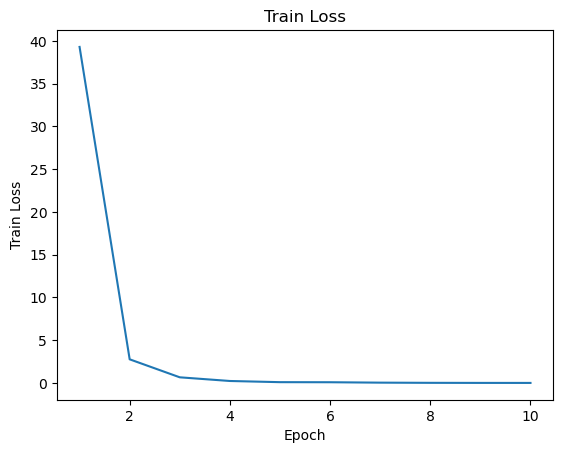

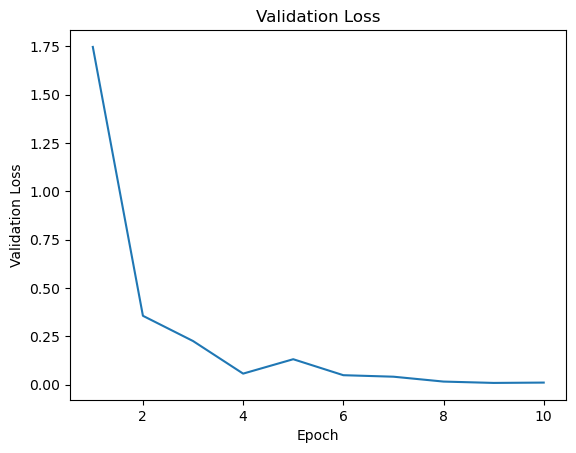

In [7]:
# Plot the train loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')
plt.show()

# Plot the validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.show()